In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import scipy.stats as stats

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression

from acquire import *
from wrangle_zillow import *

from IPython.display import Markdown

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = get_zillow_data()

<center><h2>Summary of DataFrame</h2></center>

### Total Missing Values
> - There are 7016 missing values.
### DataFrame Head
|    |   id |   bathroomcnt |   bedroomcnt |   calculatedfinishedsquarefeet |   fips |    latitude |    longitude |   lotsizesquarefeet |   propertylandusetypeid |   rawcensustractandblock |   regionidcity |   regionidcounty |   regionidzip |   roomcnt |   yearbuilt |   structuretaxvaluedollarcnt |   taxvaluedollarcnt |   assessmentyear |   landtaxvaluedollarcnt |   taxamount |    logerror | transactiondate   | last_trans_date   |
|---:|-----:|--------------:|-------------:|-------------------------------:|-------:|------------:|-------------:|--------------------:|------------------------:|-------------------------:|---------------:|-----------------:|--------------:|----------:|------------:|-----------------------------:|--------------------:|-----------------:|------------------------:|------------:|------------:|:------------------|:------------------|
|  0 |   10 |             4 |            4 |                           3095 |   6037 | 3.42912e+07 | -1.18578e+08 |                 nan |                     269 |              6.03711e+07 |          12447 |             3101 |         96356 |         0 |        2016 |                       138760 |              192544 |             2016 |                   53784 |     2460.72 |  0.00596317 | 2017-01-02        | 2017-01-02        |
|  1 |   20 |             2 |            4 |                           3633 |   6037 | 3.456e+07   | -1.1817e+08  |                9826 |                     261 |              6.03791e+07 |          40227 |             3101 |         97329 |         0 |        2005 |                       222321 |              296425 |             2016 |                   74104 |     6941.39 |  0.0424629  | 2017-01-02        | 2017-01-02        |
|  2 |   28 |             4 |            5 |                           2865 |   6037 | 3.38792e+07 | -1.18361e+08 |                4990 |                     246 |              6.03762e+07 |          33612 |             3101 |         96124 |         0 |        1972 |                       271704 |              831224 |             2016 |                  559520 |    10455.4  |  0.20647    | 2017-01-02        | 2017-01-02        |
|  3 |   30 |             2 |            2 |                           1090 |   6037 | 3.39741e+07 | -1.18423e+08 |               40247 |                     266 |              6.03728e+07 |          12447 |             3101 |         96072 |         0 |        2004 |                       232897 |              357568 |             2016 |                  124671 |     6165.36 |  0.0218525  | 2017-01-02        | 2017-01-02        |
|  4 |   31 |             4 |            3 |                           1620 |   6037 | 3.39962e+07 | -1.18438e+08 |                 nan |                     261 |              6.03727e+07 |          12447 |             3101 |         96047 |         0 |        2011 |                       339532 |              847770 |             2016 |                  508238 |    10244.9  | -0.0195456  | 2017-01-02        | 2017-01-02        |

### DataFrame Info
|    | column_name                  |   nulls | dtypes   |
|---:|:-----------------------------|--------:|:---------|
|  0 | id                           |       0 | int64    |
|  1 | bathroomcnt                  |       0 | float64  |
|  2 | bedroomcnt                   |       0 | float64  |
|  3 | calculatedfinishedsquarefeet |       0 | float64  |
|  4 | fips                         |       0 | float64  |
|  5 | latitude                     |       0 | float64  |
|  6 | longitude                    |       0 | float64  |
|  7 | lotsizesquarefeet            |    5242 | float64  |
|  8 | propertylandusetypeid        |       0 | float64  |
|  9 | rawcensustractandblock       |       0 | float64  |
| 10 | regionidcity                 |    1331 | float64  |
| 11 | regionidcounty               |       0 | float64  |
| 12 | regionidzip                  |     159 | float64  |
| 13 | roomcnt                      |       0 | float64  |
| 14 | yearbuilt                    |      71 | float64  |
| 15 | structuretaxvaluedollarcnt   |      99 | float64  |
| 16 | taxvaluedollarcnt            |       6 | float64  |
| 17 | assessmentyear               |       0 | float64  |
| 18 | landtaxvaluedollarcnt        |       6 | float64  |
| 19 | taxamount                    |     102 | float64  |
| 20 | logerror                     |       0 | float64  |
| 21 | transactiondate              |       0 | object   |
| 22 | last_trans_date              |       0 | object   |

### DataFrame Description
|                              |   count |             mean |            std |             min |              25% |              50% |              75% |              max |
|:-----------------------------|--------:|-----------------:|---------------:|----------------:|-----------------:|-----------------:|-----------------:|-----------------:|
| id                           |   74244 |  38818.9         |  22348.2       |    10           |  19509.8         |  38762.5         |  58051.2         |  77613           |
| bathroomcnt                  |   74244 |      2.31222     |      1.00148   |     1           |      2           |      2           |      3           |     20           |
| bedroomcnt                   |   74244 |      3.22232     |      1.11993   |     1           |      3           |      3           |      4           |     25           |
| calculatedfinishedsquarefeet |   74244 |   1808.71        |    932.876     |   352           |   1221           |   1581           |   2141           |  26345           |
| fips                         |   74244 |   6048.26        |     20.7975    |  6037           |   6037           |   6037           |   6059           |   6111           |
| latitude                     |   74244 |      3.401e+07   | 243665         |     3.33394e+07 |      3.38344e+07 |      3.40202e+07 |      3.4173e+07  |      3.48069e+07 |
| longitude                    |   74244 |     -1.18215e+08 | 350619         |    -1.19448e+08 |     -1.18411e+08 |     -1.18186e+08 |     -1.17956e+08 |     -1.17556e+08 |
| lotsizesquarefeet            |   69002 |  23335.3         | 118135         |   343           |   5725           |   7013           |   9929.75        |      6.97101e+06 |
| propertylandusetypeid        |   74244 |    261.186       |      4.20089   |   246           |    261           |    261           |    261           |    275           |
| rawcensustractandblock       |   74244 |      6.04857e+07 | 206474         |     6.0371e+07  |      6.0373e+07  |      6.03757e+07 |      6.05904e+07 |      6.11101e+07 |
| regionidcity                 |   72913 |  35415.8         |  52702.3       |  3491           |  12447           |  25218           |  45457           | 396556           |
| regionidcounty               |   74244 |   2582.35        |    779.163     |  1286           |   2061           |   3101           |   3101           |   3101           |
| regionidzip                  |   74085 |  96558.9         |   3878.66      | 95982           |  96186           |  96378           |  96974           | 399675           |
| roomcnt                      |   74244 |      1.55885     |      2.91192   |     0           |      0           |      0           |      0           |     86           |
| yearbuilt                    |   74173 |   1964.63        |     23.3592    |  1808           |   1950           |   1963           |   1982           |   2016           |
| structuretaxvaluedollarcnt   |   74145 | 176088           | 208736         |    10           |  79918           | 129628           | 206239           |      1.04024e+07 |
| taxvaluedollarcnt            |   74238 | 437283           | 540462         |     9           | 192496           | 324583           | 515000           |      3.01668e+07 |
| assessmentyear               |   74244 |   2016           |      0.0416688 |  2014           |   2016           |   2016           |   2016           |   2016           |
| landtaxvaluedollarcnt        |   74238 | 261416           | 381454         |     9           |  79264           | 175816           | 324549           |      1.97645e+07 |
| taxamount                    |   74142 |   5358.7         |   6232.73      |    20.24        |   2542.71        |   4064.68        |   6239.65        | 342940           |
| logerror                     |   74244 |      0.0168669   |      0.171047  |    -4.65542     |     -0.0242413   |      0.00674558  |      0.0394171   |      5.263       |

In [3]:
df = resolve_missing_values(df)

## Run to get summary
# print(summarize(df))

### Takeaways from Acquire:

> - Target variable: `logerror`
> - This dataframe has 74,244 rows and 23 columns
> - The dataset has 162,235 missing values
> - There are 2 `object` based dtypes.

### Data Preperation

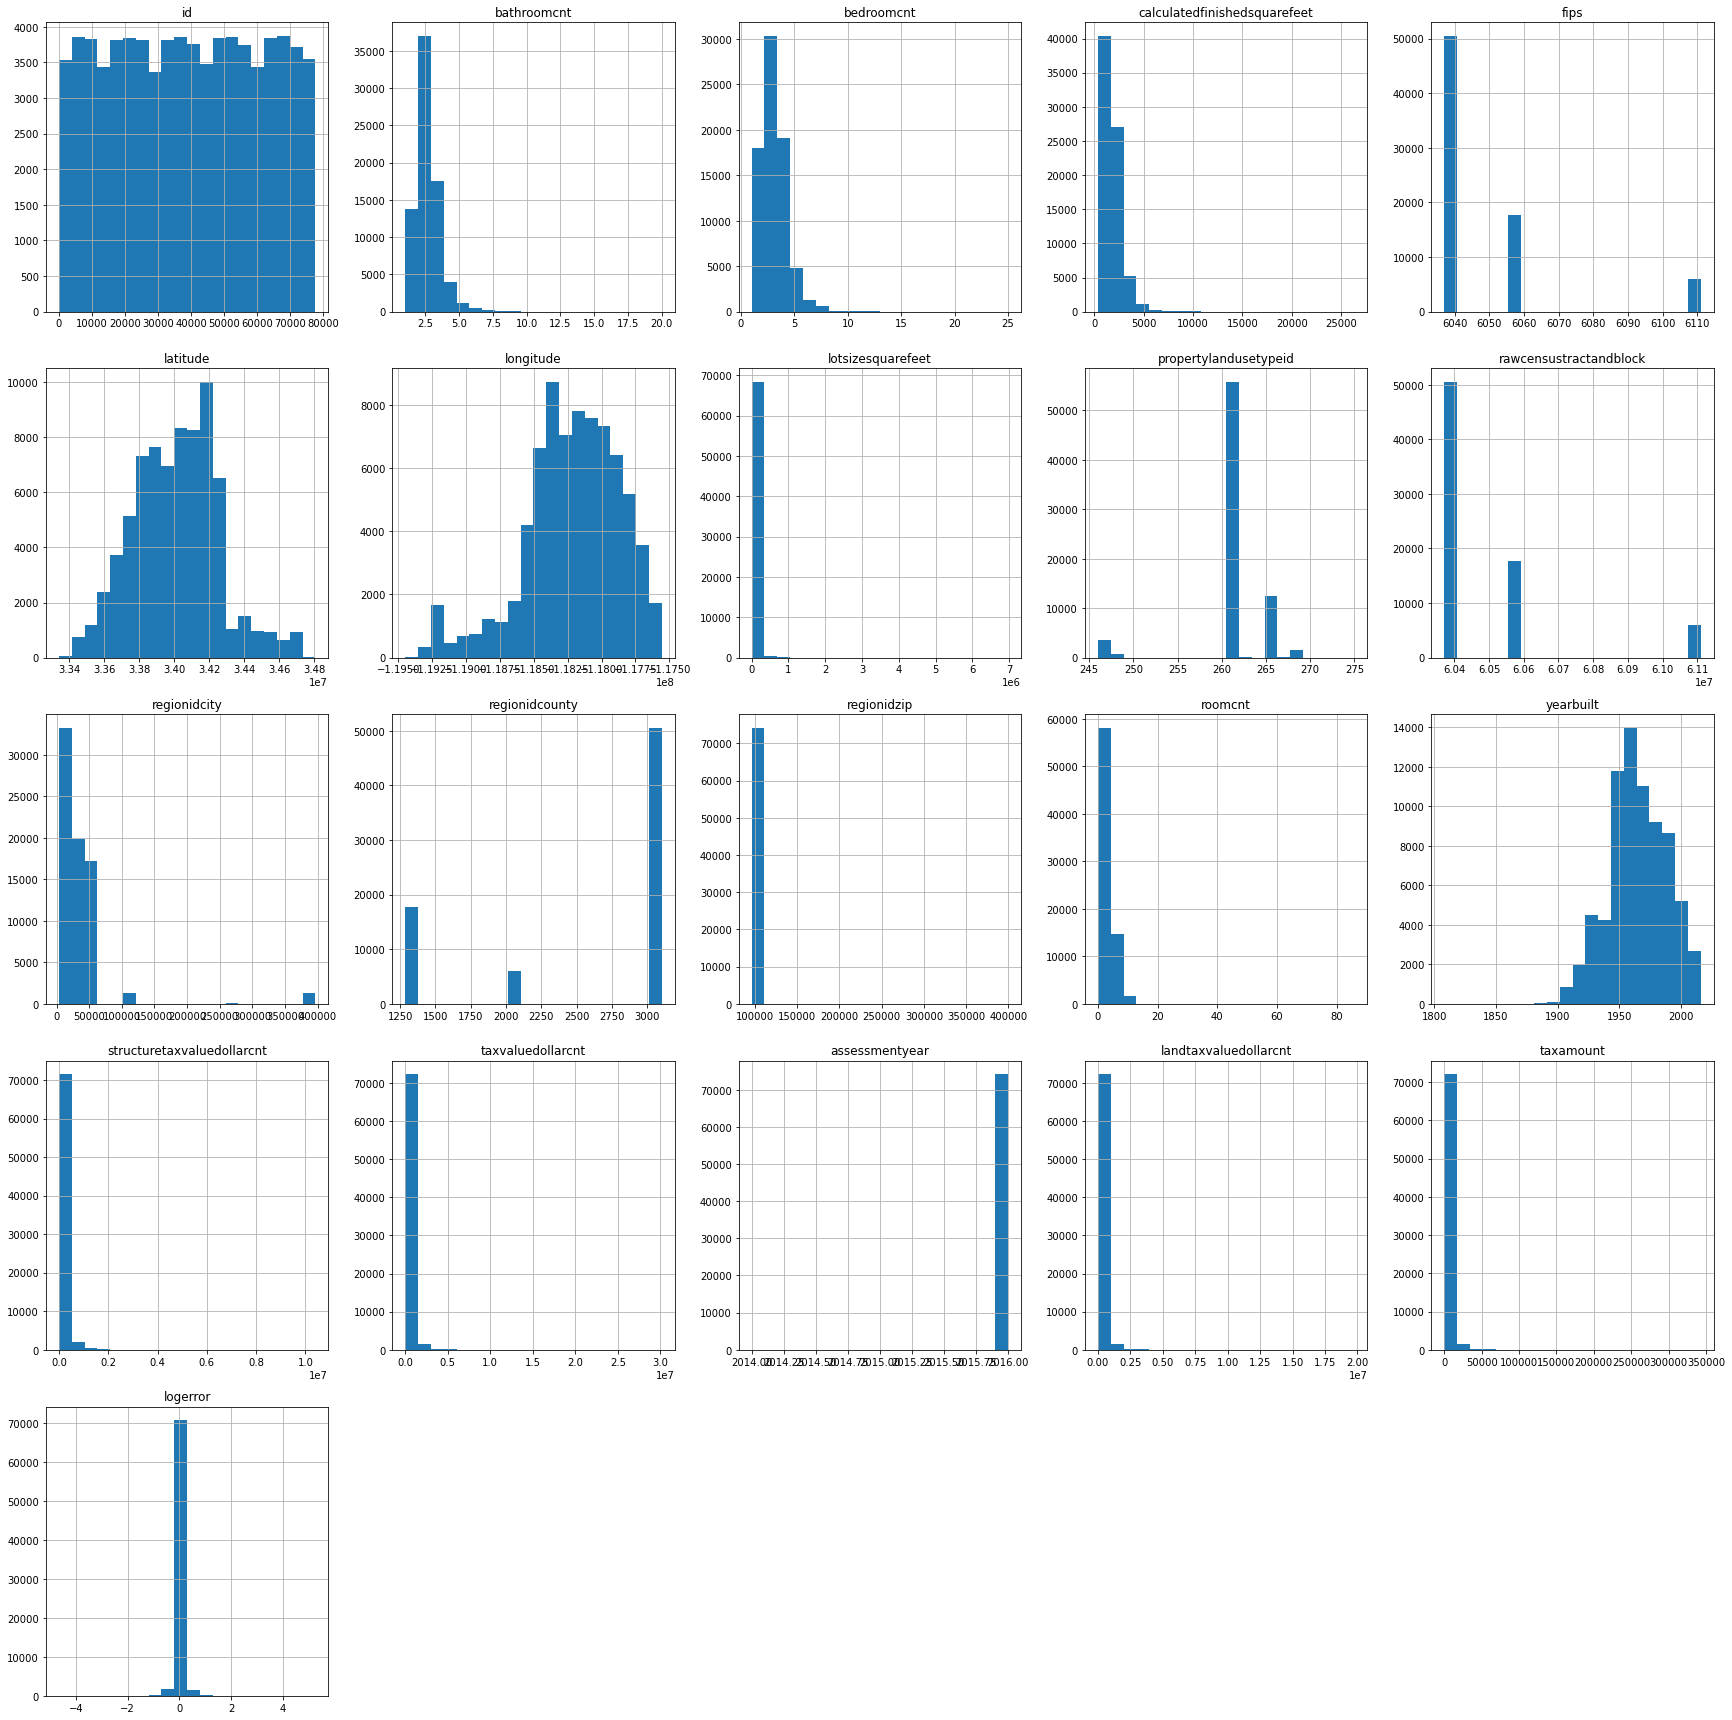

In [4]:
df.hist(figsize=(24, 24), bins=20)
plt.tight_layout()
plt.show()

In [5]:
df = wrangle(df)
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,last_trans_date,county
1,20,2.0,4.0,3633.0,6037.0,34560018.0,-118169806.0,9826.0,261.0,6.037910e+07,...,2005.0,222321.0,296425.0,2016.0,74104.0,6941.39,0.042463,2017-01-02,2017-01-02,Los Angeles
5,33,2.0,3.0,2077.0,6037.0,34012977.0,-118479243.0,6490.0,261.0,6.037702e+07,...,1926.0,210192.0,646760.0,2016.0,436568.0,7924.68,-0.040807,2017-01-02,2017-01-02,Los Angeles
8,45,2.0,4.0,1931.0,6037.0,33990297.0,-118275168.0,5420.0,246.0,6.037233e+07,...,1957.0,124789.0,224617.0,2016.0,99828.0,2885.93,0.082734,2017-01-02,2017-01-02,Los Angeles
10,75,4.0,4.0,3086.0,6037.0,34111765.0,-118045669.0,12843.0,246.0,6.037432e+07,...,1950.0,288506.0,820065.0,2016.0,531559.0,9602.77,0.000161,2017-01-02,2017-01-02,Los Angeles
12,110,1.0,3.0,1244.0,6037.0,33953559.0,-118083855.0,6021.0,261.0,6.037503e+07,...,1950.0,108040.0,169471.0,2016.0,61431.0,2532.88,0.042412,2017-01-03,2017-01-03,Los Angeles


### Split the data

In [6]:
train, validate, test = train_validate_test_split(df)
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow_split(df, 'logerror')

### Scale the data

In [7]:
# Numeric Columns to scale
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount']
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scaler(
    X_train, X_validate, X_test, cols)

X_train_scaled.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,...,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,transactiondate,last_trans_date,county
61850,64691,0.333333,0.666667,0.182293,6037.0,0.522473,0.676888,0.242636,261.0,6.037531e+07,...,0.0,0.676329,0.250049,0.419332,2016.0,0.367273,0.507793,2017-08-08,2017-08-08,Los Angeles
51997,54226,0.333333,0.333333,0.145095,6037.0,0.539345,0.822211,0.465538,261.0,6.037406e+07,...,0.0,0.690821,0.087696,0.055365,2016.0,0.035401,0.095663,2017-07-06,2017-07-06,Los Angeles
55043,57345,0.333333,0.333333,0.270829,6059.0,0.074608,0.958561,0.399705,261.0,6.059042e+07,...,6.0,0.758454,0.258077,0.132371,2016.0,0.055194,0.122010,2017-07-14,2017-07-14,Orange
31904,33504,0.000000,0.000000,0.126822,6037.0,0.405917,0.599140,0.371281,261.0,6.037604e+07,...,0.0,0.690821,0.371661,0.423923,2016.0,0.327139,0.479772,2017-05-05,2017-05-05,Los Angeles
5234,5611,0.333333,0.333333,0.187949,6037.0,0.563617,0.632638,0.355670,246.0,6.037187e+07,...,0.0,0.560386,0.244924,0.213827,2016.0,0.147810,0.248122,2017-01-26,2017-01-26,Los Angeles


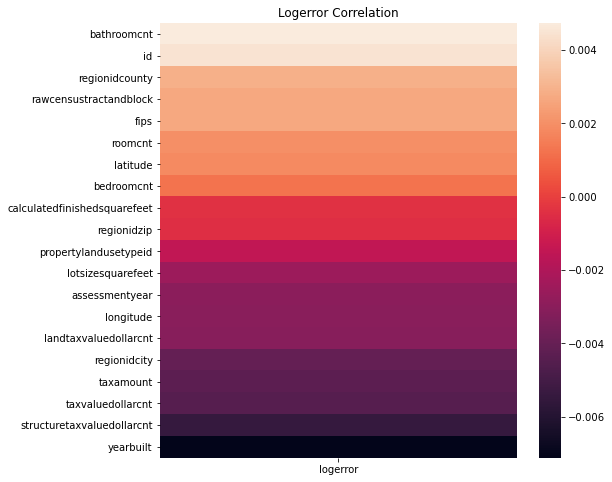

In [8]:
logerror_corr = pd.DataFrame(df.corr().logerror.sort_values(ascending=False)[1:])
plt.figure(figsize=(8,8))
sns.heatmap(logerror_corr).set(title='Logerror Correlation')
plt.show()

In [13]:
print(logerror_corr.to_markdown())

|                              |     logerror |
|:-----------------------------|-------------:|
| bathroomcnt                  |  0.00474117  |
| id                           |  0.00447373  |
| regionidcounty               |  0.00292009  |
| rawcensustractandblock       |  0.00269419  |
| fips                         |  0.00269152  |
| roomcnt                      |  0.00199583  |
| latitude                     |  0.00182852  |
| bedroomcnt                   |  0.00125381  |
| calculatedfinishedsquarefeet | -0.000362524 |
| regionidzip                  | -0.000494803 |
| propertylandusetypeid        | -0.00150166  |
| lotsizesquarefeet            | -0.00249514  |
| assessmentyear               | -0.00295415  |
| longitude                    | -0.00302902  |
| landtaxvaluedollarcnt        | -0.00305275  |
| regionidcity                 | -0.00402482  |
| taxamount                    | -0.0042753   |
| taxvaluedollarcnt            | -0.00445937  |
| structuretaxvaluedollarcnt   | -0.0054

### Feature Engineering

In [ ]:
X = X_train[list(X_train.select_dtypes(exclude=['object']).columns)]
y = y_train

#create model
lm = LinearRegression()
#select hyperparameters
rfe = RFE(estimator=lm, n_features_to_select=3)
#fit model
rfe.fit(X, y)
best_features = list(X.columns[rfe.support_])
print('Best Features:', *best_features)

In [ ]:
for col in best_features:
    plt.figure(figsize=(16,8))
    sns.lmplot(x=col, y='logerror', data=df).set(title=f'{col.title()} vs Logerror')
plt.show()

In [ ]:
cols = ['taxamount', 'bathroomcnt', 'bedroomcnt',
        'lotsizesquarefeet', 'calculatedfinishedsquarefeet',
        'latitude', 'longitude', 'assessmentyear'
       ]
sns.pairplot(data=train[cols])
plt.show()

### Hypothesis 1 Correlation Test `logerror` vs `id`
> - ${H}_{0}$: There is no correlation between `logerror` and `id`
> - ${H}_{a}$: There is a correlation between `logerror` and `id`

__r-value__: 0.00177

__p-value__: 0.76129

We fail to reject null hypothesis. There is no relationship between `logerror` and `id`

### Hypothesis 2 Correlation Test `logerror` vs `bathroomcnt`
> - ${H}_{0}$: There is no correlation between `logerror` and `bathroomcnt`
> - ${H}_{a}$: There is a correlation between `logerror` and `bathroomcnt`

__r-value__: 0.00354

__p-value__: 0.54214

We fail to reject null hypothesis. There is no relationship between `logerror` and `bathroomcnt`

### Hypothesis 3 Correlation Test `logerror` vs `bedroomcnt`
> - ${H}_{0}$: There is no correlation between `logerror` and `bedroomcnt`
> - ${H}_{a}$: There is a correlation between `logerror` and `bedroomcnt`

__r-value__: 0.00261

__p-value__: 0.65306

We fail to reject null hypothesis. There is no relationship between `logerror` and `bedroomcnt`

### Hypothesis 4 Correlation Test `logerror` vs `calculatedfinishedsquarefeet`
> - ${H}_{0}$: There is no correlation between `logerror` and `calculatedfinishedsquarefeet`
> - ${H}_{a}$: There is a correlation between `logerror` and `calculatedfinishedsquarefeet`

__r-value__: 0.00126

__p-value__: 0.82831

We fail to reject null hypothesis. There is no relationship between `logerror` and `calculatedfinishedsquarefeet`

### Hypothesis 5 Correlation Test `logerror` vs `fips`
> - ${H}_{0}$: There is no correlation between `logerror` and `fips`
> - ${H}_{a}$: There is a correlation between `logerror` and `fips`

__r-value__: 0.00893

__p-value__: 0.12424

We fail to reject null hypothesis. There is no relationship between `logerror` and `fips`

### Hypothesis 6 Correlation Test `logerror` vs `latitude`
> - ${H}_{0}$: There is no correlation between `logerror` and `latitude`
> - ${H}_{a}$: There is a correlation between `logerror` and `latitude`

__r-value__: 0.00431

__p-value__: 0.4579

We fail to reject null hypothesis. There is no relationship between `logerror` and `latitude`

### Hypothesis 7 Correlation Test `logerror` vs `longitude`
> - ${H}_{0}$: There is no correlation between `logerror` and `longitude`
> - ${H}_{a}$: There is a correlation between `logerror` and `longitude`

__r-value__: -0.00593

__p-value__: 0.30775

We fail to reject null hypothesis. There is no relationship between `logerror` and `longitude`

### Hypothesis 8 Correlation Test `logerror` vs `lotsizesquarefeet`
> - ${H}_{0}$: There is no correlation between `logerror` and `lotsizesquarefeet`
> - ${H}_{a}$: There is a correlation between `logerror` and `lotsizesquarefeet`

__r-value__: 0.00451

__p-value__: 0.43719

We fail to reject null hypothesis. There is no relationship between `logerror` and `lotsizesquarefeet`

### Hypothesis 9 Correlation Test `logerror` vs `propertylandusetypeid`
> - ${H}_{0}$: There is no correlation between `logerror` and `propertylandusetypeid`
> - ${H}_{a}$: There is a correlation between `logerror` and `propertylandusetypeid`

__r-value__: -0.00323

__p-value__: 0.57885

We fail to reject null hypothesis. There is no relationship between `logerror` and `propertylandusetypeid`

### Hypothesis 10 Correlation Test `logerror` vs `rawcensustractandblock`
> - ${H}_{0}$: There is no correlation between `logerror` and `rawcensustractandblock`
> - ${H}_{a}$: There is a correlation between `logerror` and `rawcensustractandblock`

__r-value__: 0.00899

__p-value__: 0.12193

We fail to reject null hypothesis. There is no relationship between `logerror` and `rawcensustractandblock`

### Hypothesis 11 Correlation Test `logerror` vs `regionidcity`
> - ${H}_{0}$: There is no correlation between `logerror` and `regionidcity`
> - ${H}_{a}$: There is a correlation between `logerror` and `regionidcity`

__r-value__: -0.00361

__p-value__: 0.53397

We fail to reject null hypothesis. There is no relationship between `logerror` and `regionidcity`

### Hypothesis 12 Correlation Test `logerror` vs `regionidcounty`
> - ${H}_{0}$: There is no correlation between `logerror` and `regionidcounty`
> - ${H}_{a}$: There is a correlation between `logerror` and `regionidcounty`

__r-value__: 0.00272

__p-value__: 0.63938

We fail to reject null hypothesis. There is no relationship between `logerror` and `regionidcounty`

### Hypothesis 13 Correlation Test `logerror` vs `regionidzip`
> - ${H}_{0}$: There is no correlation between `logerror` and `regionidzip`
> - ${H}_{a}$: There is a correlation between `logerror` and `regionidzip`

__r-value__: 0.00262

__p-value__: 0.65193

We fail to reject null hypothesis. There is no relationship between `logerror` and `regionidzip`

### Hypothesis 14 Correlation Test `logerror` vs `roomcnt`
> - ${H}_{0}$: There is no correlation between `logerror` and `roomcnt`
> - ${H}_{a}$: There is a correlation between `logerror` and `roomcnt`

__r-value__: 0.00274

__p-value__: 0.63711

We fail to reject null hypothesis. There is no relationship between `logerror` and `roomcnt`

### Hypothesis 15 Correlation Test `logerror` vs `yearbuilt`
> - ${H}_{0}$: There is no correlation between `logerror` and `yearbuilt`
> - ${H}_{a}$: There is a correlation between `logerror` and `yearbuilt`

__r-value__: -0.00734

__p-value__: 0.20623

We fail to reject null hypothesis. There is no relationship between `logerror` and `yearbuilt`

### Hypothesis 16 Correlation Test `logerror` vs `structuretaxvaluedollarcnt`
> - ${H}_{0}$: There is no correlation between `logerror` and `structuretaxvaluedollarcnt`
> - ${H}_{a}$: There is a correlation between `logerror` and `structuretaxvaluedollarcnt`

__r-value__: -0.00581

__p-value__: 0.31743

We fail to reject null hypothesis. There is no relationship between `logerror` and `structuretaxvaluedollarcnt`

### Hypothesis 17 Correlation Test `logerror` vs `taxvaluedollarcnt`
> - ${H}_{0}$: There is no correlation between `logerror` and `taxvaluedollarcnt`
> - ${H}_{a}$: There is a correlation between `logerror` and `taxvaluedollarcnt`

__r-value__: -0.00617

__p-value__: 0.2884

We fail to reject null hypothesis. There is no relationship between `logerror` and `taxvaluedollarcnt`

### Hypothesis 18 Correlation Test `logerror` vs `assessmentyear`
> - ${H}_{0}$: There is no correlation between `logerror` and `assessmentyear`
> - ${H}_{a}$: There is a correlation between `logerror` and `assessmentyear`

__r-value__: -0.00386

__p-value__: 0.50658

We fail to reject null hypothesis. There is no relationship between `logerror` and `assessmentyear`

### Hypothesis 19 Correlation Test `logerror` vs `landtaxvaluedollarcnt`
> - ${H}_{0}$: There is no correlation between `logerror` and `landtaxvaluedollarcnt`
> - ${H}_{a}$: There is a correlation between `logerror` and `landtaxvaluedollarcnt`

__r-value__: -0.00499

__p-value__: 0.39029

We fail to reject null hypothesis. There is no relationship between `logerror` and `landtaxvaluedollarcnt`

### Hypothesis 20 Correlation Test `logerror` vs `taxamount`
> - ${H}_{0}$: There is no correlation between `logerror` and `taxamount`
> - ${H}_{a}$: There is a correlation between `logerror` and `taxamount`

__r-value__: -0.00624

__p-value__: 0.28312

We fail to reject null hypothesis. There is no relationship between `logerror` and `taxamount`

In [ ]:
alpha = .05
columns = list(train.columns)
tests = { col : ('pearson' if col not in ['bedroomcnt'] else 'ttest') for col in columns}
result = ''
count = 1
for col, test in tests.items():
    try:
        result += f"### Hypothesis {count} {test.capitalize()} Test `logerror` vs `{col}`\n"
        result += '> - ${H}_{0}$: There is no correlation between `logerror` and ' + f'`{col}`\n'
        result += '> - ${H}_{a}$: There is a correlation between `logerror` and ' + f'`{col}`\n\n'
        
        if test == 'pearson':
            r, p = stats.pearsonr(train.logerror, train[col])
        else:
            r, p = stats.ttest_ind(train[col], train.logerror, equal_var=False)
            
        count += 1
        result += f'__r-value__: {round(r, 5)}\n\n__p-value__: {round(p, 5)}\n\n'

        if p < alpha: 
            result += f"We reject our null hypothesis. There is a relationship between `logerror` and `{col}`\n\n"
        else:
            result += f"We fail to reject null hypothesis. There is no relationship between `logerror` and `{col}`\n\n"
    except:
        pass
# print this to generate all hypothesis test
print(result)

### Cluster 1 

In [ ]:
X = train[['bathroomcnt', 'lotsizesquarefeet']]
X.head()

In [ ]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.info()

In [ ]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# PLot scatterplots
create_scatterplots(X_scaled, cn='bathroomcnt', c2='lotsizesquarefeet')

In [ ]:
train, X_scaled, scaler, kmeans, centroids_scaled = create_cluster(
    train, X, 5, col_name= 'cluster_ltsze_batrmct')
train.head()go

In [ ]:
## Plot only k == 5 because it's the part where it's a 45 degree angle
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'bathroomcnt', y = 'lotsizesquarefeet', data = train, hue = 'cluster_ltsze_batrmct')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='lotsizesquarefeet', x= 'bathroomcnt', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of lotsizesquarefeet and bathroomcnt')
plt.show()

### Cluster 1 takeaways:
> - It appears the change inertia slope starts to approach 0 around k=5.

### Cluster 2

In [ ]:
X2 = train[['calculatedfinishedsquarefeet', 'bedroomcnt']]
X2.head()

In [ ]:
# Scale the values to create the clusters
scaler = StandardScaler().fit(X2)
X2_scaled = pd.DataFrame(scaler.transform(X2), columns= X2.columns).set_index([X2.index.values])

# Plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
train, X2_scaled, scaler, kmeans, centroids_scaled = create_cluster(
    train, X2, 5, col_name= 'cluster_calcsfinshqft_bdrmcnt')
train.head()

In [ ]:
## Plot only k == 5 because it's the part where it's a 45 degree angle
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'bedroomcnt', y = 'calculatedfinishedsquarefeet', data = train, hue = 'cluster_calcsfinshqft_bdrmcnt')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X2_scaled.columns)
centroids.plot.scatter(y='calculatedfinishedsquarefeet', x= 'bedroomcnt', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of calculatedfinishedsquarefeet and bedroomcnt')
plt.show()

### Cluster 2 takeaways:
> - It appears the change inertia slope starts to approach 0 around k=5.

### Cluster 3

In [ ]:
X3 = train[['bathroomcnt', 'yearbuilt']]
X3.head()

In [ ]:
# Scale the values to create the clusters
scaler = StandardScaler().fit(X3)
X3_scaled = pd.DataFrame(scaler.transform(X3), columns= X3.columns).set_index([X3.index.values])

# Plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
train, X3_scaled, scaler, kmeans, centroids_scaled = create_cluster(
    train, X3, 4, col_name= 'cluster_yrblt_bthrmcnt')
train.head()

In [ ]:
## Plot only k == 4 because it's the part where it's a 45 degree angle
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'bathroomcnt', y = 'yearbuilt', data = train, hue = 'cluster_yrblt_bthrmcnt')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X3_scaled.columns)
centroids.plot.scatter(y='yearbuilt', x= 'bathroomcnt', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of bathroomcnt and yearbuilt')
plt.show()

### Cluster 3 takeaways:
> - It appears the change inertia slope starts to approach 0 around k=4.

In [ ]:
%%html 
<style>
table {margin-left: 0 !important;}
</style>